## How can we rapidly explore different network parameters?
- The standard approach would be to duplicate the entire simulation (files and code) and rerun many times
- Of course, this could be scripted, and allows networks of arbitrary complexity
- For simple single-cell cases, we can instead simulate them together in a single (disconnected) network
- To use batch_builder, just replace any property to be varied by a list!

Note that this should in theory work for simulating copies of *different* cells in the same network, but there is a limitation of BMTK that needs to be resolved before that will work.

In [34]:
sm = setup.SimManager.from_template(config_template=template, overwrite=True, config_path=new_config)

distance_list = np.linspace(0, 350, 5)
edge_props['distance_range_max'] = distance_list

# Note that we need to use a short-hand here to avoid extra lists
# 'ab' means 'apical and basal'
edge_props['target_sections'] = ['a','ab','s']

input_props = {'input_rate': np.linspace(1, 4000, 10)}

net = batch_builder.build_batch_all(sm, node_props, edge_props, input_props, n_duplicates=2)
print "{n} nodes in batch.".format(n=net.nnodes)

300 nodes in batch.


In [ ]:
# Need a slightly more complicated approach to truly restrict the synapse placement
interval = 10
linked_edge_props = {'distance_range_min':distance_list, 'distance_range_max':distance_list+interval}
net = batch_builder.build_batch_all(sm, node_props, edge_props, input_props, n_duplicates=4,
                                   linked_dicts=[linked_edge_props])

In [33]:
sm.run_bionet_mpi(ncores=4)

/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
NEURON -- VERSION 7.5 master (6b4c19f) 2017-09-25
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2016
See http://neuron.yale.edu/neuron/credits

Additional mechanisms from files
 modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/Kd.mod modfiles/K_P.mod modfiles/K_Pst.mod modfiles/K_T.mod modfiles/K_Tst.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/Nap_Et2.mod modfiles/Nap.mod modfiles/NaTa.mod modfiles/NaTa_t.mod modfiles/NaTg.mod modfiles/NaTs2_t.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/SK.mod modfiles/vecevent.mod

numprocs=4
2019-01-15 10:09:05,474 [INFO] Created log file
2019-01-15 10:09:05,491 [INFO] Running NEURON with mpi (4 cores).
2019-01-15 10:09:05,702 [INFO] Building cells.
2019-01-15 10:09:16,444 [INFO] Building recurrent connections
2019-01-15 1

## How can we make sense of the results?
- Get the data into a Pandas dataframe (table), then run some plots and analysis
- Note: most of this could apply to network simulations too, to sort how simulation results relate to different node properties over the network.

In [73]:
import pandas as pd
import ateam.analysis.spikes as spikes
import ateam.analysis.nodes as nodes
import matplotlib.pyplot as plt

rates = spikes.get_rates_config(sm.config_path)
# nodes_df = batch_builder.read_node_props_batch(sm.sim_folder)
net_name = 'batch'
nodes_df = nodes.create_node_table(sm.nodes_file(net_name), sm.node_types_file(net_name))
nodes_df.head()

,node_type_id,distance_range_max,input_rate,target_sections,dynamics_params,model_processing,morphology,model_template,model_type,cell_name
node_id,,,,,,,,,,
0,100,0.0,1.0,a,optim_param_525133308.json,aibs_allactive,525133308.swc,ctdb:Biophys1.hoc,biophysical,525133308
1,100,0.0,1.0,a,optim_param_525133308.json,aibs_allactive,525133308.swc,ctdb:Biophys1.hoc,biophysical,525133308
2,100,87.5,1.0,a,optim_param_525133308.json,aibs_allactive,525133308.swc,ctdb:Biophys1.hoc,biophysical,525133308
3,100,87.5,1.0,a,optim_param_525133308.json,aibs_allactive,525133308.swc,ctdb:Biophys1.hoc,biophysical,525133308
4,100,175.0,1.0,a,optim_param_525133308.json,aibs_allactive,525133308.swc,ctdb:Biophys1.hoc,biophysical,525133308


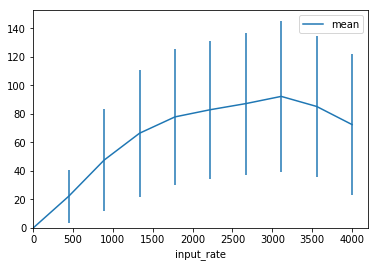

In [54]:
df = nodes_df.join(pd.Series(rates, name='rate')).fillna(0)
df_agg = df.groupby('input_rate').agg(['mean','std'])
df_agg['rate'].plot(y='mean', yerr='std')
plt.axis(xmin=0, ymin=0)
plt.show()

We really want a bit more analysis to account for all the properties we varied.

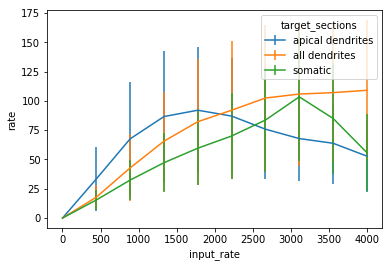

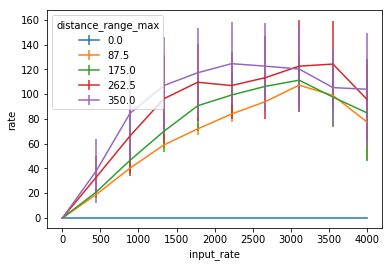

In [62]:
import ateam.analysis.batch_analysis as batch_analysis

df_stats = batch_analysis.plot_df_stats_comparison(df, xvar='input_rate', yvar='rate', compare='target_sections')
plt.legend(['apical dendrites','all dendrites', 'somatic'], title='target_sections')
plt.show()

df_stats = batch_analysis.plot_df_stats_comparison(df, xvar='input_rate', yvar='rate', compare='distance_range_max')
# plt.legend(['apical dendrites','all dendrites', 'somatic'])
plt.show()

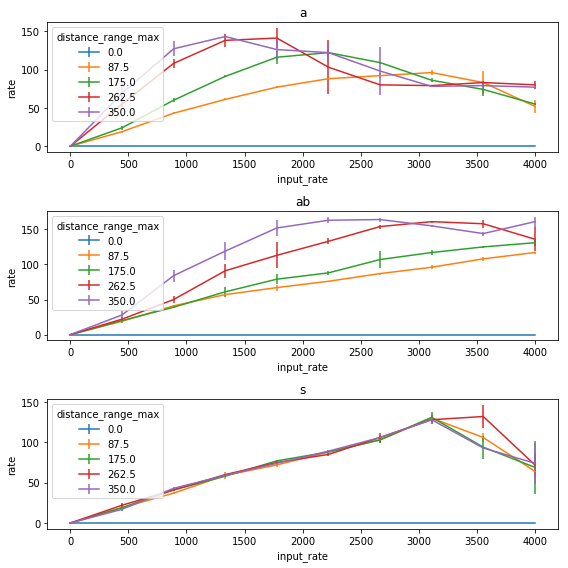

In [71]:
df_stats = batch_analysis.plot_df_stats_comparison_multiple(df, xvar='input_rate', yvar='rate', 
                                                compare='distance_range_max', separate='target_sections', figsize=(8,8))
plt.show()

## One more example: analysis of single EPSPs
- This time we can put all our code into a function to make it easy to re-run

In [105]:
def build_epsp_batch(cell_id, gsyn=1e-4, n_duplicates=10):
    edge_props = {
        'nsyns': 5,
        'syn_weight': gsyn,
        'delay': 0,
        'dynamics_params': 'AMPA_ExcToExc.json',
        'model_template': 'exp2syn',
        'target_sections': ['a','b'],
        'distance_range_min': 0,
        'distance_range_max': 200
    }
    node_props = {
        'cell_name': cell_id,
        'morphology': '{}.swc'.format(cell_id),
        'dynamics_params': 'optim_param_{}.json'.format(cell_id),
        'model_type': 'biophysical',
        'model_template': 'ctdb:Biophys1.hoc',
        'model_processing': 'aibs_allactive'
    }
    
    new_config = './sim_files/{}/batch_config.json'.format(cell_id)
    template = "/allen/aibs/mat/ateam_shared/bmtk_networks_share/default_config.json"
    sm = setup.SimManager.from_template(config_template=template, overwrite=True, config_path=new_config)
    
    opt_params_path = "/allen/aibs/mat/ateam_shared/All_active_Human/PC"
    sm.config.update_nested(components={"biophysical_neuron_models_dir": opt_params_path})
    
    sm.add_membrane_report()

    distance_list = np.linspace(0, 350, 4)
    interval = 20
    distance_range_dict = {'distance_range_min':distance_list, 'distance_range_max':distance_list+interval}
    input_props = {'spike_times': [0.3]}

    net = batch_builder.build_batch_all(sm, node_props, edge_props, input_props, n_duplicates=n_duplicates,
                                       linked_dicts=[distance_range_dict])
    return sm

In [75]:
import ateam.analysis.cell_vars.psp_analysis as psp

def extract_psp_data(sm):
    net = 'batch'
    nodes_df = nodes.create_node_table(sm.nodes_file(net), sm.node_types_file(net))
    spike_time = 0.3
    props = psp.epsp_analysis(config_file=sm.config_path, t_min=100, t_duration=1000, t_spike=1000*spike_time)
    syn_df = pd.DataFrame(props)
    syn_df.set_index('gid', inplace=True)
    df = syn_df.join(nodes_df)
    return df

In [111]:
cell_id = 525133308
sm = build_epsp_batch(cell_id, gsyn=1e-5, n_duplicates=5)
sm.run_bionet_mpi(ncores=4)
df = extract_psp_data(sm)

/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
NEURON -- VERSION 7.5 master (6b4c19f) 2017-09-25
Duke, Yale, and the BlueBrain Project -- Copyright 1984-2016
See http://neuron.yale.edu/neuron/credits

Additional mechanisms from files
 modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/Kd.mod modfiles/K_P.mod modfiles/K_Pst.mod modfiles/K_T.mod modfiles/K_Tst.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/Nap_Et2.mod modfiles/Nap.mod modfiles/NaTa.mod modfiles/NaTa_t.mod modfiles/NaTg.mod modfiles/NaTs2_t.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/SK.mod modfiles/vecevent.mod

numprocs=4
2019-01-15 11:56:44,562 [INFO] Created log file
2019-01-15 11:56:44,588 [INFO] Running NEURON with mpi (4 cores).
2019-01-15 11:56:44,836 [INFO] Building cells.
2019-01-15 11:56:46,220 [INFO] Building recurrent connections
2019-01-15 1

mean       std
distance_range_max target_sections                    
20.000000          a                5.502878  0.678754
                   b                7.337613  0.399197
136.666667         a                6.213227  0.409086
                   b                7.918367  1.747352
253.333333         a                5.897360  0.301140
                   b                6.926759  0.281384
370.000000         a                6.221667  0.455009
                   b                7.289877  0.131965

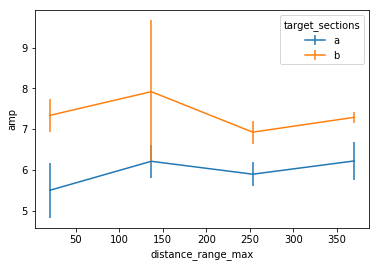

In [112]:
batch_analysis.plot_df_stats_comparison(df,'distance_range_max', 'amp', 'target_sections')